In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import sddk

import google_conf
import pickle
import numpy as np

from gensim.matutils import corpus2csc
from gensim.corpora import Dictionary
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText

In [2]:
# point out to your google service account and a google sheet URL to which you wish to send your data
theos_data = google_conf.setup(sheet_url="https://docs.google.com/spreadsheets/d/19gfECdrg5rDiU2PhNYL1nKifeKzemCfYtYrAHQX5vXE/edit?usp=sharing", service_account_path="../../ServiceAccountsKey.json")

In [3]:
# global parameters for plots
#plt.style.use("fast")
plt.style.use("seaborn-v0_8-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

In [4]:
LAGT = pd.read_parquet("../data/large_data/LAGT_theos.parquet")

# Frequencies

In [5]:
centuries = [(str(int(n / -100)) + "BCE",  n, n+ 99) for n in range(-800, 0, 100)] + [(str(int(n / 100)) + "CE",  n - 99, n) for n in range(100, 700, 100)]
centuries

[('8BCE', -800, -701),
 ('7BCE', -700, -601),
 ('6BCE', -600, -501),
 ('5BCE', -500, -401),
 ('4BCE', -400, -301),
 ('3BCE', -300, -201),
 ('2BCE', -200, -101),
 ('1BCE', -100, -1),
 ('1CE', 1, 100),
 ('2CE', 101, 200),
 ('3CE', 201, 300),
 ('4CE', 301, 400),
 ('5CE', 401, 500),
 ('6CE', 501, 600)]

In [6]:
with open("../data/subcorpora_ids_dict.pickle", "rb") as f:
    subcorpora_ids_dict= pickle.load(f)

In [7]:
religion_final = ["θεός", "Ζεύς", "εὐσεβής", 'ἱερός']
morality_final = ["ἀγαθός", "ἀρετή", "δίκαιος", "τιμή"]

In [8]:
centuries_targets = []
for cent in centuries:
    century_data = {}
    century_data["cent"] = cent
    LAGT_subset = LAGT[LAGT["cents"].apply(lambda x: cent[0] in x)]
    works_lemmata = LAGT_subset["lemmatized_sentences"].apply(lambda x: [l for s in x for l in s])
    subset_lemmata = [l for work in works_lemmata for l in work]
    subset_wordcount = LAGT_subset["wordcount"].sum()
    for target in religion_final + morality_final:
        target_n = subset_lemmata.count(target)
        century_data[target + "_n"] = target_n
        century_data[target + "_freq"] = target_n / subset_wordcount
    centuries_targets.append(century_data)

centuries_targets_df = pd.DataFrame(centuries_targets)
centuries_targets_df

,cent,θεός_n,θεός_freq,Ζεύς_n,Ζεύς_freq,εὐσεβής_n,εὐσεβής_freq,ἱερός_n,ἱερός_freq,ἀγαθός_n,ἀγαθός_freq,ἀρετή_n,ἀρετή_freq,δίκαιος_n,δίκαιος_freq,τιμή_n,τιμή_freq
0,"(8BCE, -800, -701)",897,0.004117,850,0.003902,0,0.000000,100,0.000459,141,0.000647,41,0.000188,25,0.000115,59,0.000271
1,"(7BCE, -700, -601)",185,0.006708,212,0.007688,0,0.000000,26,0.000943,22,0.000798,4,0.000145,11,0.000399,34,0.001233
2,"(6BCE, -600, -501)",570,0.004711,450,0.003719,12,0.000099,33,0.000273,117,0.000967,68,0.000562,56,0.000463,74,0.000612
3,"(5BCE, -500, -401)",4590,0.002015,2249,0.000987,94,0.000041,846,0.000371,5919,0.002598,1205,0.000529,1900,0.000834,497,0.000218
4,"(4BCE, -400, -301)",3591,0.001043,1784,0.000518,61,0.000018,616,0.000179,8606,0.002499,2148,0.000624,3110,0.000903,716,0.000208
5,"(3BCE, -300, -201)",4662,0.002082,357,0.000159,40,0.000018,266,0.000119,1428,0.000638,498,0.000222,686,0.000306,213,0.000095
6,"(2BCE, -200, -101)",4519,0.003012,96,0.000064,42,0.000028,179,0.000119,802,0.000535,108,0.000072,591,0.000394,180,0.000120
7,"(1BCE, -100, -1)",5062,0.002734,548,0.000296,83,0.000045,1226,0.000662,2911,0.001572,1793,0.000969,918,0.000496,795,0.000429
8,"(1CE, 1, 100)",11581,0.002651,1112,0.000255,138,0.000032,1888,0.000432,5564,0.001274,2525,0.000578,1792,0.000410,1698,0.000389
9,"(2CE, 101, 200)",22374,0.001895,4295,0.000364,244,0.000021,2408,0.000204,15968,0.001353,4000,0.000339,3749,0.000318,1979,0.000168


In [9]:
centuries_targets_df["cents_mid"] = centuries_targets_df["cent"].apply(lambda x: int((x[1] + x[2]) / 2))
centuries_targets_df.set_index("cents_mid", inplace=True)
centuries_targets_df["cent_label"] = centuries_targets_df["cent"].apply(lambda x: x[0])
centuries_targets_df

,cent,θεός_n,θεός_freq,Ζεύς_n,Ζεύς_freq,εὐσεβής_n,εὐσεβής_freq,ἱερός_n,ἱερός_freq,ἀγαθός_n,ἀγαθός_freq,ἀρετή_n,ἀρετή_freq,δίκαιος_n,δίκαιος_freq,τιμή_n,τιμή_freq,cent_label
cents_mid,,,,,,,,,,,,,,,,,,
-750,"(8BCE, -800, -701)",897,0.004117,850,0.003902,0,0.000000,100,0.000459,141,0.000647,41,0.000188,25,0.000115,59,0.000271,8BCE
-650,"(7BCE, -700, -601)",185,0.006708,212,0.007688,0,0.000000,26,0.000943,22,0.000798,4,0.000145,11,0.000399,34,0.001233,7BCE
-550,"(6BCE, -600, -501)",570,0.004711,450,0.003719,12,0.000099,33,0.000273,117,0.000967,68,0.000562,56,0.000463,74,0.000612,6BCE
-450,"(5BCE, -500, -401)",4590,0.002015,2249,0.000987,94,0.000041,846,0.000371,5919,0.002598,1205,0.000529,1900,0.000834,497,0.000218,5BCE
-350,"(4BCE, -400, -301)",3591,0.001043,1784,0.000518,61,0.000018,616,0.000179,8606,0.002499,2148,0.000624,3110,0.000903,716,0.000208,4BCE
-250,"(3BCE, -300, -201)",4662,0.002082,357,0.000159,40,0.000018,266,0.000119,1428,0.000638,498,0.000222,686,0.000306,213,0.000095,3BCE
-150,"(2BCE, -200, -101)",4519,0.003012,96,0.000064,42,0.000028,179,0.000119,802,0.000535,108,0.000072,591,0.000394,180,0.000120,2BCE
-50,"(1BCE, -100, -1)",5062,0.002734,548,0.000296,83,0.000045,1226,0.000662,2911,0.001572,1793,0.000969,918,0.000496,795,0.000429,1BCE
50,"(1CE, 1, 100)",11581,0.002651,1112,0.000255,138,0.000032,1888,0.000432,5564,0.001274,2525,0.000578,1792,0.000410,1698,0.000389,1CE


In [10]:
centuries_targets_df

,cent,θεός_n,θεός_freq,Ζεύς_n,Ζεύς_freq,εὐσεβής_n,εὐσεβής_freq,ἱερός_n,ἱερός_freq,ἀγαθός_n,ἀγαθός_freq,ἀρετή_n,ἀρετή_freq,δίκαιος_n,δίκαιος_freq,τιμή_n,τιμή_freq,cent_label
cents_mid,,,,,,,,,,,,,,,,,,
-750,"(8BCE, -800, -701)",897,0.004117,850,0.003902,0,0.000000,100,0.000459,141,0.000647,41,0.000188,25,0.000115,59,0.000271,8BCE
-650,"(7BCE, -700, -601)",185,0.006708,212,0.007688,0,0.000000,26,0.000943,22,0.000798,4,0.000145,11,0.000399,34,0.001233,7BCE
-550,"(6BCE, -600, -501)",570,0.004711,450,0.003719,12,0.000099,33,0.000273,117,0.000967,68,0.000562,56,0.000463,74,0.000612,6BCE
-450,"(5BCE, -500, -401)",4590,0.002015,2249,0.000987,94,0.000041,846,0.000371,5919,0.002598,1205,0.000529,1900,0.000834,497,0.000218,5BCE
-350,"(4BCE, -400, -301)",3591,0.001043,1784,0.000518,61,0.000018,616,0.000179,8606,0.002499,2148,0.000624,3110,0.000903,716,0.000208,4BCE
-250,"(3BCE, -300, -201)",4662,0.002082,357,0.000159,40,0.000018,266,0.000119,1428,0.000638,498,0.000222,686,0.000306,213,0.000095,3BCE
-150,"(2BCE, -200, -101)",4519,0.003012,96,0.000064,42,0.000028,179,0.000119,802,0.000535,108,0.000072,591,0.000394,180,0.000120,2BCE
-50,"(1BCE, -100, -1)",5062,0.002734,548,0.000296,83,0.000045,1226,0.000662,2911,0.001572,1793,0.000969,918,0.000496,795,0.000429,1BCE
50,"(1CE, 1, 100)",11581,0.002651,1112,0.000255,138,0.000032,1888,0.000432,5564,0.001274,2525,0.000578,1792,0.000410,1698,0.000389,1CE


In [11]:
centuries_targets_df.to_csv("../data/centuries_targets.csv")

In [14]:
#google_conf.set_with_dataframe(theos_data.add_worksheet("centuries_targets", 1,1), centuries_targets_df)

In [15]:
colors_list = ["olive"] * 4 + ["chocolate"] * 4

In [16]:
colors = ["darkblue", "darkgreen", "darkred"]
periods_colors = ['lightcyan',
                  'lightgoldenrodyellow',
                  'lavender',
                  'lightgreen',
                  'lightpink']
periods_dict = {  # to avoid overlaps, startdates are postponed by one year, when needed
    "archaic": {"startdate": -800, "enddate": -501},
    "classical": {"startdate": -500, "enddate": -301},
    "hellenistic": {"startdate": -300, "enddate": 0},
    "roman_peak": {"startdate": 1, "enddate": 200},
    "roman_late": {"startdate": 201, "enddate": 600}}

Text(-0.02, 0.5, 'word frequency')

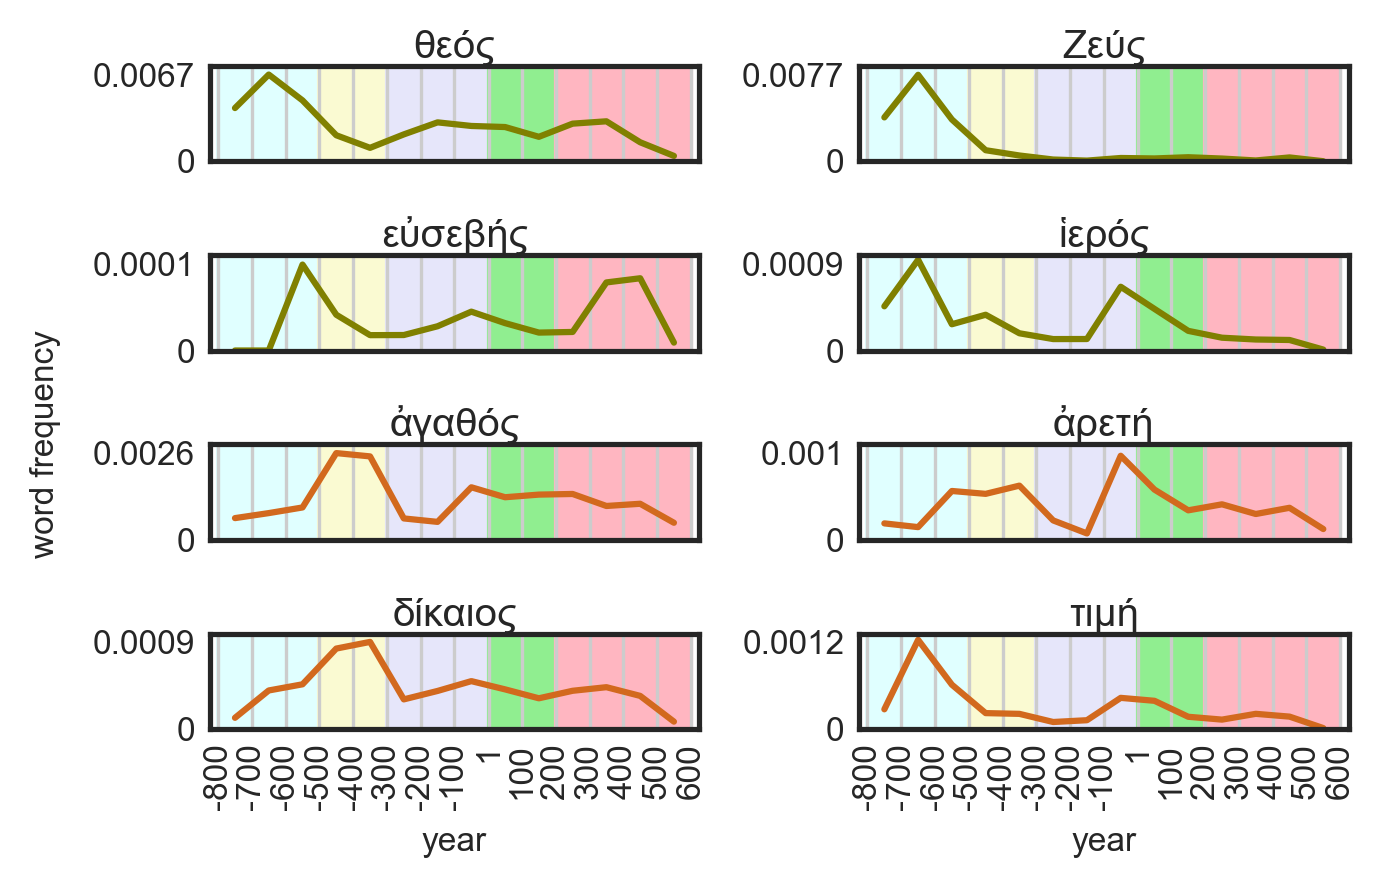

In [18]:
fig, axs = plt.subplots(4,2, figsize=(4.45, 3), tight_layout=True)

for target, ax, color in zip(religion_final + morality_final, axs.ravel(), colors_list):
    for period, color_per in zip(periods_dict.keys(), periods_colors):
        ax.axvspan(periods_dict[period]["startdate"], periods_dict[period]["enddate"], color=color_per, zorder=-1)
    #midpoint = (periods_dict[period]["startdate"] + periods_dict[period]["enddate"]) / 2  # calculate midpoint for label
    #ax.annotate(period, (midpoint, ax.get_ylim()[1] * 0.95), xytext=(0, 10),
    #            textcoords='offset points', ha='center', va='bottom', rotation=90)
    centuries_targets_df[target + "_freq"].plot(ax=ax, color=color)
    y_max = centuries_targets_df[target + "_freq"].max().round(4)
    ax.set_ylim(0, y_max * 1.1)
    ax.set_yticks([int(0), y_max])
    ax.set_yticklabels([str(tick) for tick in [int(0), y_max]])
    ax.set_xlabel("")
    ax.set_xticklabels([])
    #ax.grid(visible=True, axis="y")
    ax.grid(visible=True, axis="x")
    ax.set_title(target, pad=0)
    ax.set_xticks([el+1 if el==0 else el for el in range(-800,700,100)])
    ax.set_xlim(-825,625)


axs[3,0].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,700,100)], rotation=90)
axs[3,1].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,700,100)], rotation=90)

axs[3,0].set_xlabel("year")
axs[3,1].set_xlabel("year")

fig.text(-0.02, 0.5, 'word frequency', va='center', rotation='vertical')

In [19]:
save_figure(fig, "word_frequencies")

In [20]:
centuries_provenience_targets = []
for cent in centuries:
    century_data = {}
    century_data["cent"] = cent
    for provenience in ["pagan", "christian", "jewish"]:
        LAGT_subset = LAGT[(LAGT["cents"].apply(lambda x: cent[0] in x)) & (LAGT["provenience"]==provenience)]
        works_lemmata = LAGT_subset["lemmatized_sentences"].apply(lambda x: [l for s in x for l in s])
        subset_lemmata = [l for work in works_lemmata for l in work]
        subset_wordcount = LAGT_subset["wordcount"].sum()
        for target in religion_final + morality_final:
            target_n = subset_lemmata.count(target)
            century_data[target + "_" + provenience + "_n"] = target_n
            try:
                century_data[target + "_" + provenience + "_freq"] = target_n / subset_wordcount
            except:
                century_data[target + "_" + provenience + "_freq"] = 0
    centuries_provenience_targets.append(century_data)

centuries_provenience_targets_df = pd.DataFrame(centuries_provenience_targets)
centuries_provenience_targets_df

/var/folders/57/tg7c_g894t5c2z3swkqzds5h0000gn/T/ipykernel_6462/847871853.py:14: RuntimeWarning: invalid value encountered in scalar divide
  century_data[target + "_" + provenience + "_freq"] = target_n / subset_wordcount


,cent,θεός_pagan_n,θεός_pagan_freq,Ζεύς_pagan_n,Ζεύς_pagan_freq,εὐσεβής_pagan_n,εὐσεβής_pagan_freq,ἱερός_pagan_n,ἱερός_pagan_freq,ἀγαθός_pagan_n,...,ἱερός_jewish_n,ἱερός_jewish_freq,ἀγαθός_jewish_n,ἀγαθός_jewish_freq,ἀρετή_jewish_n,ἀρετή_jewish_freq,δίκαιος_jewish_n,δίκαιος_jewish_freq,τιμή_jewish_n,τιμή_jewish_freq
0,"(8BCE, -800, -701)",897,0.004117,850,0.003902,0,0.000000e+00,100,0.000459,141,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
1,"(7BCE, -700, -601)",185,0.006708,212,0.007688,0,0.000000e+00,26,0.000943,22,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
2,"(6BCE, -600, -501)",570,0.004711,450,0.003719,12,9.918175e-05,33,0.000273,117,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
3,"(5BCE, -500, -401)",4590,0.002017,2249,0.000988,94,4.129733e-05,846,0.000372,5905,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
4,"(4BCE, -400, -301)",3588,0.001043,1784,0.000518,61,1.772528e-05,616,0.000179,8600,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
5,"(3BCE, -300, -201)",805,0.000590,355,0.000260,7,5.127172e-06,160,0.000117,935,...,106,0.000122,487,0.000558,32,0.000037,415,0.000476,77,0.000088
6,"(2BCE, -200, -101)",645,0.001057,94,0.000154,9,1.474808e-05,73,0.000120,313,...,106,0.000119,489,0.000550,32,0.000036,424,0.000476,79,0.000089
7,"(1BCE, -100, -1)",1968,0.001799,530,0.000484,57,5.209828e-05,924,0.000845,1549,...,302,0.000400,1360,0.001801,958,0.001269,316,0.000419,316,0.000419
8,"(1CE, 1, 100)",3771,0.001333,1034,0.000366,53,1.874057e-05,1015,0.000359,3178,...,790,0.000651,1879,0.001549,1248,0.001029,612,0.000505,682,0.000562
9,"(2CE, 101, 200)",9236,0.000923,3880,0.000388,163,1.628271e-05,2243,0.000224,13724,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN


In [21]:
centuries_provenience_targets_df[['cent', 'ἀρετή_pagan_freq', 'ἀρετή_christian_freq', 'ἀρετή_jewish_freq']]

,cent,ἀρετή_pagan_freq,ἀρετή_christian_freq,ἀρετή_jewish_freq
0,"(8BCE, -800, -701)",0.000188,NaN,NaN
1,"(7BCE, -700, -601)",0.000145,NaN,NaN
2,"(6BCE, -600, -501)",0.000562,NaN,NaN
3,"(5BCE, -500, -401)",0.000527,NaN,NaN
4,"(4BCE, -400, -301)",0.000624,NaN,NaN
5,"(3BCE, -300, -201)",0.000340,NaN,0.000037
6,"(2BCE, -200, -101)",0.000123,NaN,0.000036
7,"(1BCE, -100, -1)",0.000762,NaN,0.001269
8,"(1CE, 1, 100)",0.000445,0.000052,0.001029
9,"(2CE, 101, 200)",0.000307,0.000517,NaN


In [22]:
centuries_provenience_targets_df["cents_mid"] = centuries_provenience_targets_df["cent"].apply(lambda x: int((x[1] + x[2]) / 2))
centuries_provenience_targets_df.set_index("cents_mid", inplace=True)
centuries_provenience_targets_df["cent_label"] = centuries_provenience_targets_df["cent"].apply(lambda x: x[0])

Text(-0.02, 0.5, 'word frequency')

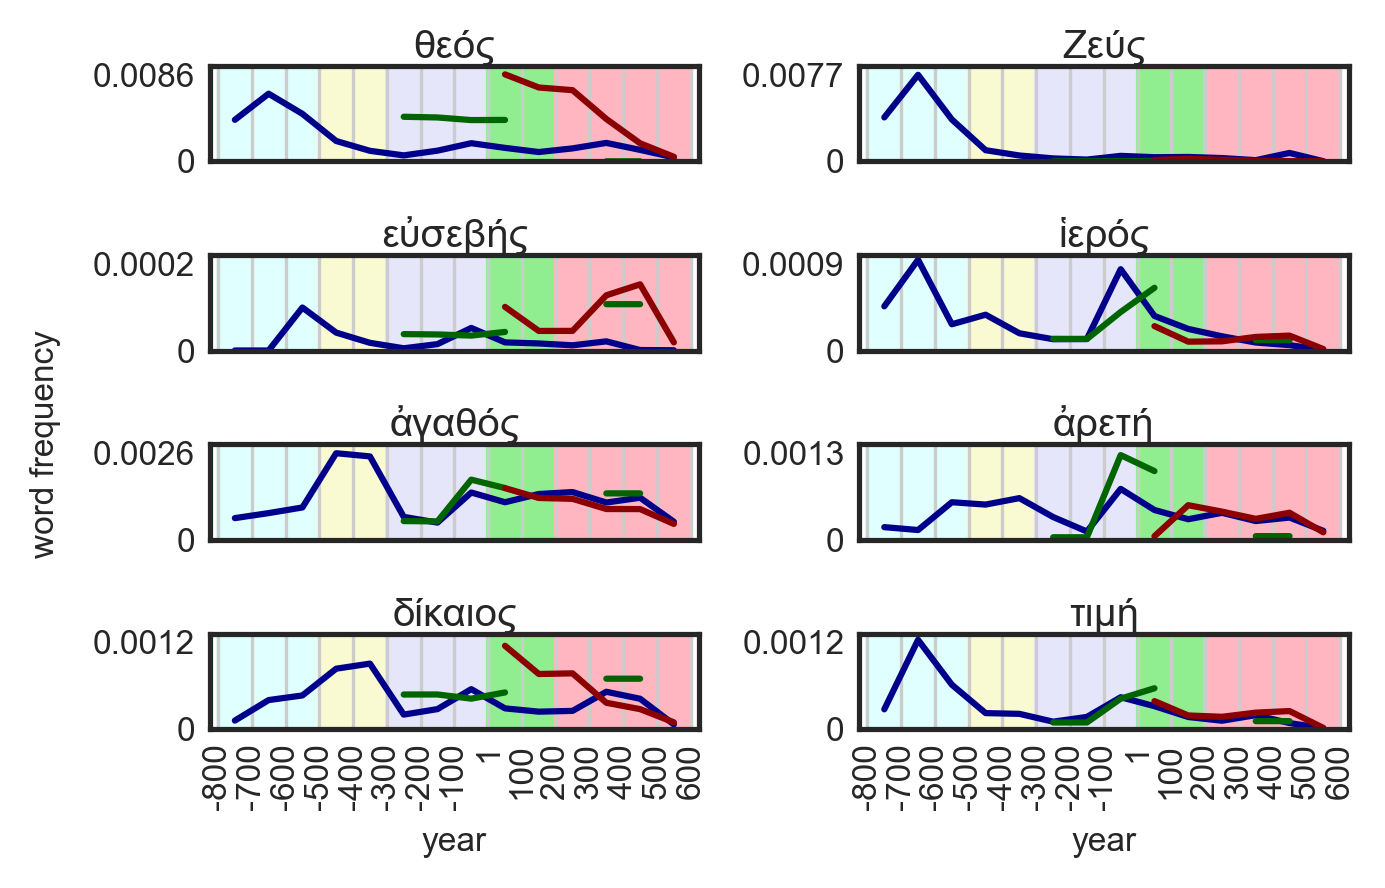

In [23]:
fig, axs = plt.subplots(4,2, figsize=(4.45, 3), tight_layout=True)

for target, ax, color in zip(religion_final + morality_final, axs.ravel(), colors_list):
    for period, color_per in zip(periods_dict.keys(), periods_colors):
        ax.axvspan(periods_dict[period]["startdate"], periods_dict[period]["enddate"], color=color_per, zorder=-1)
    #midpoint = (periods_dict[period]["startdate"] + periods_dict[period]["enddate"]) / 2  # calculate midpoint for label
    #ax.annotate(period, (midpoint, ax.get_ylim()[1] * 0.95), xytext=(0, 10),
    #            textcoords='offset points', ha='center', va='bottom', rotation=90)
    y_maxes = []
    for provenience, prov_color in zip(["pagan", "jewish", "christian"], ["darkblue", "darkgreen", "darkred"]):
        centuries_provenience_targets_df[target + "_" + provenience + "_freq"].plot(ax=ax, color=prov_color)
        y_maxes.append(centuries_provenience_targets_df[target + "_" + provenience + "_freq"].max().round(4))
    y_max = max(y_maxes)
    ax.set_ylim(0, y_max * 1.1)
    ax.set_yticks([int(0), y_max])
    ax.set_yticklabels([str(tick) for tick in [int(0), y_max]])
    ax.set_xlabel("")
    ax.set_xticklabels([])
    #ax.grid(visible=True, axis="y")
    ax.grid(visible=True, axis="x")
    ax.set_title(target, pad=0)
    ax.set_xticks([el+1 if el==0 else el for el in range(-800,700,100)])
    ax.set_xlim(-825,625)


axs[3,0].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,700,100)], rotation=90)
axs[3,1].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,700,100)], rotation=90)

axs[3,0].set_xlabel("year")
axs[3,1].set_xlabel("year")

fig.text(-0.02, 0.5, 'word frequency', va='center', rotation='vertical')

In [24]:
save_figure(fig, "word_frequencies_provenieces")

In [25]:
def freq_in_sents(row, target):
    try:
        target_n = [l for sent in row["lemmatized_sentences"] for l in sent].count(target)
        wordcount = row["wordcount"]
        target_freq = target_n # / wordcount
    except:
        target_n = 0
        target_freq = 0
    return target_n 
    
for target in religion_final + morality_final:
    LAGT[target + "_n"] = LAGT.apply(lambda row: freq_in_sents(row, target), axis=1)

In [26]:
for target in religion_final + morality_final:
    LAGT[target + "_freq"] = LAGT[target + "_n"] / LAGT["wordcount"]

In [27]:
wordfreqs_df = pd.read_json("../data/large_data/wordfreqs_df.json")
subcorpora_targets_freqs = pd.concat([wordfreqs_df.loc[religion_final], wordfreqs_df.loc[morality_final]]).T
subcorpora_targets_freqs

,θεός,Ζεύς,εὐσεβής,ἱερός,ἀγαθός,ἀρετή,δίκαιος,τιμή
pagan_archaic,0.007376,0.006542,0.000060,0.000673,0.001296,0.000548,0.000407,0.000668
pagan_classical,0.002739,0.001317,0.000059,0.000541,0.004561,0.001140,0.001735,0.000430
pagan_hellenistic,0.002149,0.000697,0.000050,0.000837,0.001925,0.001005,0.000669,0.000476
pagan_roman_peak,0.001998,0.000854,0.000036,0.000558,0.002955,0.000674,0.000512,0.000358
pagan_roman_late,0.003477,0.000625,0.000037,0.000337,0.003574,0.000978,0.000934,0.000384
christian_roman_peak,0.017661,0.000521,0.000129,0.000280,0.003129,0.001087,0.001984,0.000505
christian_roman_late,0.013185,0.000215,0.000236,0.000306,0.002578,0.000881,0.001291,0.000500
jewish,0.010871,0.000052,0.000107,0.001102,0.002939,0.001572,0.001288,0.000937


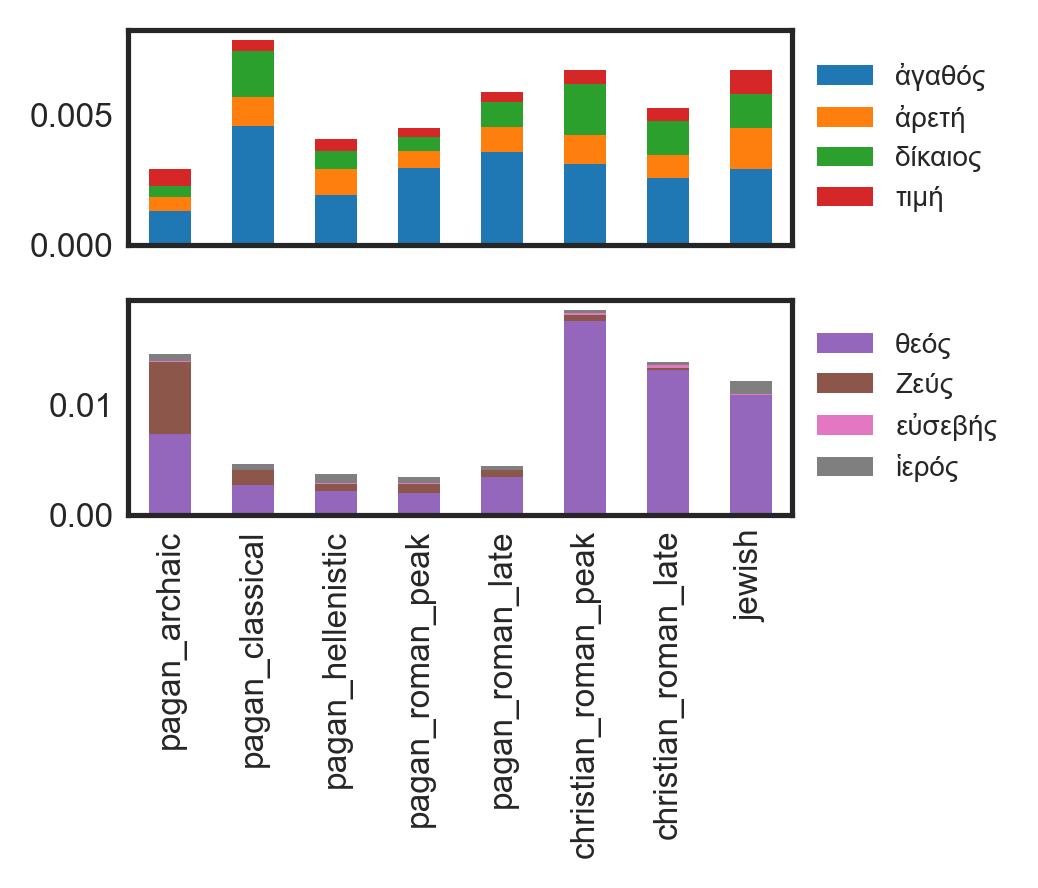

In [28]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

fig, [ax1, ax2] = plt.subplots(2,1, figsize=(3.5, 3), tight_layout=True)
subcorpora_targets_freqs[morality_final].plot(kind='bar', color=colors[:4], stacked=True, ax=ax1)
ax1.legend(fontsize="small", loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_xticklabels([])
subcorpora_targets_freqs[religion_final].plot(kind='bar', color=colors[4:], stacked=True, ax=ax2)
ax2.legend(fontsize="small", loc='center left', bbox_to_anchor=(1, 0.5))


# Cooccurrences

In [29]:
with open("../data/vocabulary_balanced.pickle", "rb") as f:
    vocabulary_balanced = pickle.load(f)

In [30]:
dictionary = Dictionary([vocabulary_balanced])

In [31]:
#dictionary.add_documents([["moralindicator"]])

In [32]:
ids_lines = pickle.load(open("../data/ids_lines_wide.pickle", "rb"))

In [33]:
list(ids_lines.items())[:5]

[('ogl0001.ogl001', (0, 25)),
 ('tlg0005.tlg003', (25, 70)),
 ('tlg0006.tlg020', (70, 5712)),
 ('tlg0007.tlg146', (5712, 6527)),
 ('tlg0007.tlg147', (6527, 6587))]

In [34]:
cent = "7BCE"
subcorpus_ids = LAGT[LAGT["cents"].apply(lambda x: cent in x)]["doc_id"].tolist()
len(subcorpus_ids)

34

In [35]:
subcorpus_ids

['tlg0629.tlg001',
 'tlg0013.tlg001',
 'tlg0013.tlg002',
 'tlg0013.tlg003',
 'tlg0013.tlg005',
 'tlg0013.tlg006',
 'tlg0013.tlg008',
 'tlg0013.tlg009',
 'tlg0013.tlg010',
 'tlg0013.tlg011',
 'tlg0013.tlg012',
 'tlg0013.tlg013',
 'tlg0013.tlg014',
 'tlg0013.tlg015',
 'tlg0013.tlg016',
 'tlg0013.tlg017',
 'tlg0013.tlg018',
 'tlg0013.tlg020',
 'tlg0013.tlg021',
 'tlg0013.tlg022',
 'tlg0013.tlg023',
 'tlg0013.tlg024',
 'tlg0013.tlg025',
 'tlg0013.tlg026',
 'tlg0013.tlg027',
 'tlg0013.tlg028',
 'tlg0013.tlg029',
 'tlg0013.tlg030',
 'tlg0013.tlg031',
 'tlg0013.tlg032',
 'tlg0013.tlg033',
 'tlg0020.tlg001',
 'tlg0020.tlg002',
 'tlg0020.tlg003']

In [36]:
cents_sents_ngrams = []
for cent in centuries:
    docs = []
    century_data = {}
    century_data["cent_label"] = cent[0]
    century_data["cent_mid"] = (cent[1] + cent[2]) / 2
    LAGT_subset = LAGT[LAGT["cents"].apply(lambda x: cent[0] in x)]
    n_sents = len([sent for sents in LAGT_subset["lemmatized_sentences"] for sent in sents])
    subcorpus_ids = LAGT_subset["doc_id"].tolist()
    with open("../data/large_data/corpus_ngrams_bydocid_wide.txt", "r") as f:
        lines = f.readlines()
        for id in subcorpus_ids:
            lines_list = [l for l in range(ids_lines[id][0], ids_lines[id][1])]
            for li in lines_list:
                try:
                    line = lines[li]
                    # for line index in subcorpus lineindexes
                    if bool(line.split()):
                        docs.append(line.split())
                except:
                    pass
    cents_sents_ngrams.append({
        "cent" : cent[0], 
        "sents_n" : n_sents,
        "ngrams_n" : len([doc for doc in docs])})

In [37]:
cents_sents_ngrams_df = pd.DataFrame(cents_sents_ngrams)
cents_sents_ngrams_df

,cent,sents_n,ngrams_n
0,8BCE,16465,82595
1,7BCE,2033,11796
2,6BCE,10776,43583
3,5BCE,159843,826817
4,4BCE,227817,1097516
5,3BCE,112579,533468
6,2BCE,64774,357936
7,1BCE,118612,702661
8,1CE,261238,1421351
9,2CE,726607,3469002


In [38]:
def get_sents_ngrams_data(LAGT_subset):
    n_sents = len([sent for sents in LAGT_subset["lemmatized_sentences"] for sent in sents])
    subcorpus_ids = LAGT_subset["doc_id"].tolist()
    with open("../data/large_data/corpus_ngrams_bydocid_wide.txt", "r") as f:
        lines = f.readlines()
    docs = []
    for id in subcorpus_ids:
        lines_list = [l for l in range(ids_lines[id][0], ids_lines[id][1])]
        for li in lines_list:
            try:
                line = lines[li]
                # for line index in subcorpus lineindexes
                if bool(line.split()):
                    docs.append(line.split())
            except:
                pass
    sents_ngrams_data = {
        "sents_n" : n_sents,
        "ngrams_n" : len([doc for doc in docs])}
    return sents_ngrams_data

In [39]:
periods_sents_ngrams = []
for sub in (subcorpora_ids_dict.keys()):
    LAGT_subset = LAGT[LAGT["doc_id"].isin(subcorpora_ids_dict[sub])]
    sents_ngrams_data = get_sents_ngrams_data(LAGT_subset)
    sents_ngrams_data["subcorpus"] = sub
    periods_sents_ngrams.append(sents_ngrams_data)

periods_sents_ngrams_df = pd.DataFrame(periods_sents_ngrams)
periods_sents_ngrams_df

,sents_n,ngrams_n,subcorpus
0,27254,126230,pagan_archaic
1,278422,1354952,pagan_classical
2,158342,902024,pagan_hellenistic
3,662484,3258617,pagan_roman_peak
4,348171,1208051,pagan_roman_late
5,146138,541951,christian_roman_peak
6,261267,966986,christian_roman_late
7,97685,562478,jewish


# Simple co-occurrences within sentences

In [40]:
religionmoral_sents_all = []
religionmoral_cooc_freqs = []
for sub in (subcorpora_ids_dict.keys()):
    religionmoral_info = {"subcorpus" : sub} 
    religionmoral_sents = []
    LAGT_subset = LAGT[LAGT["doc_id"].isin(subcorpora_ids_dict[sub])]
    sents = [sent for sents in LAGT_subset["lemmatized_sentences"] for sent in sents]
    sents_n = len(sents)
    for sent in sents:
        if any(element in sent for element in morality_final) and any(element in sent for element in religion_final):            
            religionmoral_sents.append(sent)
            religionmoral_sents_all.append((sub, list(sent)))
    religionmoral_info["religionmoral_freq"] = len(religionmoral_sents) / sents_n
    religionmoral_cooc_freqs.append(religionmoral_info)

In [41]:
religionmoral_sents_all[:10]

[('pagan_archaic',
  ['βούλομαι',
   'θεός',
   'τιμή',
   'ἄνθρωπος',
   'ἔχω',
   'πᾶς',
   'ἀγαθός',
   'δοτῆρω',
   'κακός',
   'ἀποτρόπους',
   'ὑπάρχω']),
 ('pagan_archaic',
  ['ἐπιγνός',
   'δῶρον',
   'ἄνθρωπος',
   'προσκυνέω',
   'εὐχαριστέω',
   'οἴχομαι',
   'θεός',
   'λόγος',
   'τιμηθέντων',
   'πᾶς',
   'ἔχω',
   'τίς',
   'τιμή',
   'ζηλόω',
   'ἀναίσθης',
   'ἄλογος',
   'ζῷον']),
 ('pagan_archaic',
  ['Ζεύς', 'πίθῳ', 'ἀγαθός', 'συγκλείω', 'ἀφίημι', 'ἄνθρωπος']),
 ('pagan_archaic',
  ['Ζεύς', 'πίθῳ', 'ἀγαθός', 'ἐγκατακλείω', 'ἀφίημι', 'ἄνθρωπος']),
 ('pagan_archaic',
  ['συμβαίνω',
   'ἄνθρωπος',
   'Ζεύς',
   'χρόνος',
   'γίγνομαι',
   'ἀκέραιος',
   'ἀγαθός']),
 ('pagan_archaic',
  ['φημί',
   'πᾶς',
   'διαιρετός',
   'ἀδιαίρετος',
   'γενητός',
   'ἀγένητος',
   'θνητός',
   'ἀθάνατος',
   'λόγος',
   'αἰών',
   'πατήρ',
   'υἱός',
   'θεός',
   'δίκαιος']),
 ('pagan_archaic',
  ['Πηλείδης',
   'ἐθέλω',
   'ἐρίζω',
   'βασιλεύς',
   'ὁμοῖος',
   'μείρομαι',
   'τ

In [42]:
religionmoral_cooc_freqs_df = pd.DataFrame(religionmoral_cooc_freqs)

In [43]:
subcorpora_colors_dict = {
    'pagan_archaic': 'darkgreen',
    'pagan_classical':  'darkgreen',
    'pagan_hellenistic': 'darkgreen',  
    'pagan_roman_peak' : 'darkgreen',
    'pagan_roman_late' : 'darkgreen',
    'christian_roman_peak' : 'darkred',
    'christian_roman_late' : 'darkred',
    'jewish': 'darkblue'}


[Text(0, 0, 'pagan_archaic'),
 Text(1, 0, 'pagan_classical'),
 Text(2, 0, 'pagan_hellenistic'),
 Text(3, 0, 'pagan_roman_peak'),
 Text(4, 0, 'pagan_roman_late'),
 Text(5, 0, 'christian_roman_peak'),
 Text(6, 0, 'christian_roman_late'),
 Text(7, 0, 'jewish')]

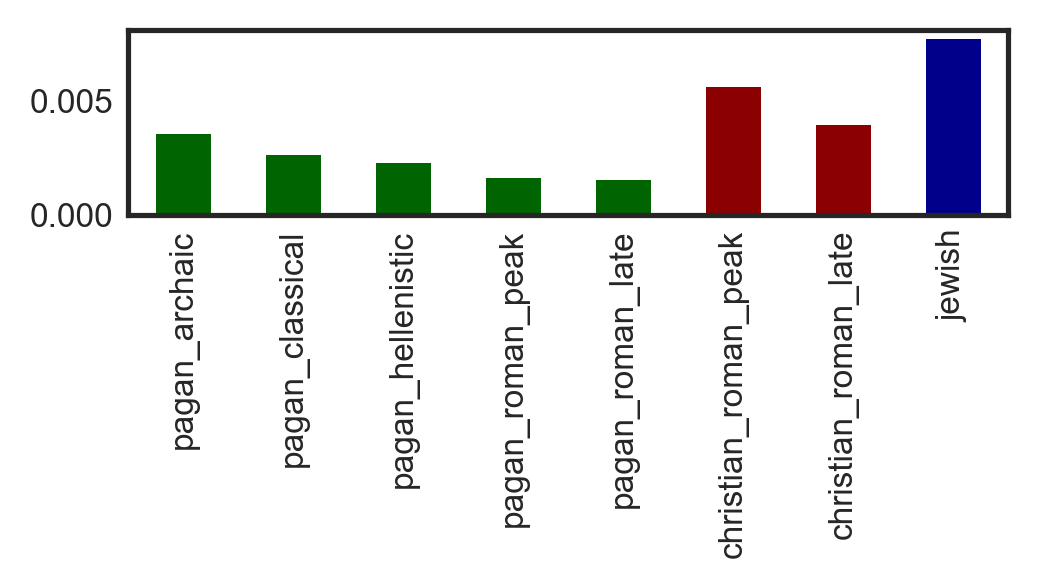

In [44]:
fig, ax = plt.subplots(figsize=(3.5, 2), tight_layout=True)
religionmoral_cooc_freqs_df["religionmoral_freq"].plot.bar(color=subcorpora_colors_dict.values())
ax.set_xticklabels(subcorpora_ids_dict.keys())

In [45]:
subcorpora_ids_dict.keys()

dict_keys(['pagan_archaic', 'pagan_classical', 'pagan_hellenistic', 'pagan_roman_peak', 'pagan_roman_late', 'christian_roman_peak', 'christian_roman_late', 'jewish'])

In [46]:
subcorpora_labels = ["archaic\n(8-6BCE)", "classical\n(5-4BCE)", "hellenistic\n(3-1BCE)", "roman\n(1-2CE)", "roman\n(3-6CE)", "christian\n(1-2CE)", "christian\n(3-6CE)", "jewish"]

[Text(0, 0, 'archaic\n(8-6BCE)'),
 Text(1, 0, 'classical\n(5-4BCE)'),
 Text(2, 0, 'hellenistic\n(3-1BCE)'),
 Text(3, 0, 'roman\n(1-2CE)'),
 Text(4, 0, 'roman\n(3-6CE)'),
 Text(5, 0, 'christian\n(1-2CE)'),
 Text(6, 0, 'christian\n(3-6CE)'),
 Text(7, 0, 'jewish')]

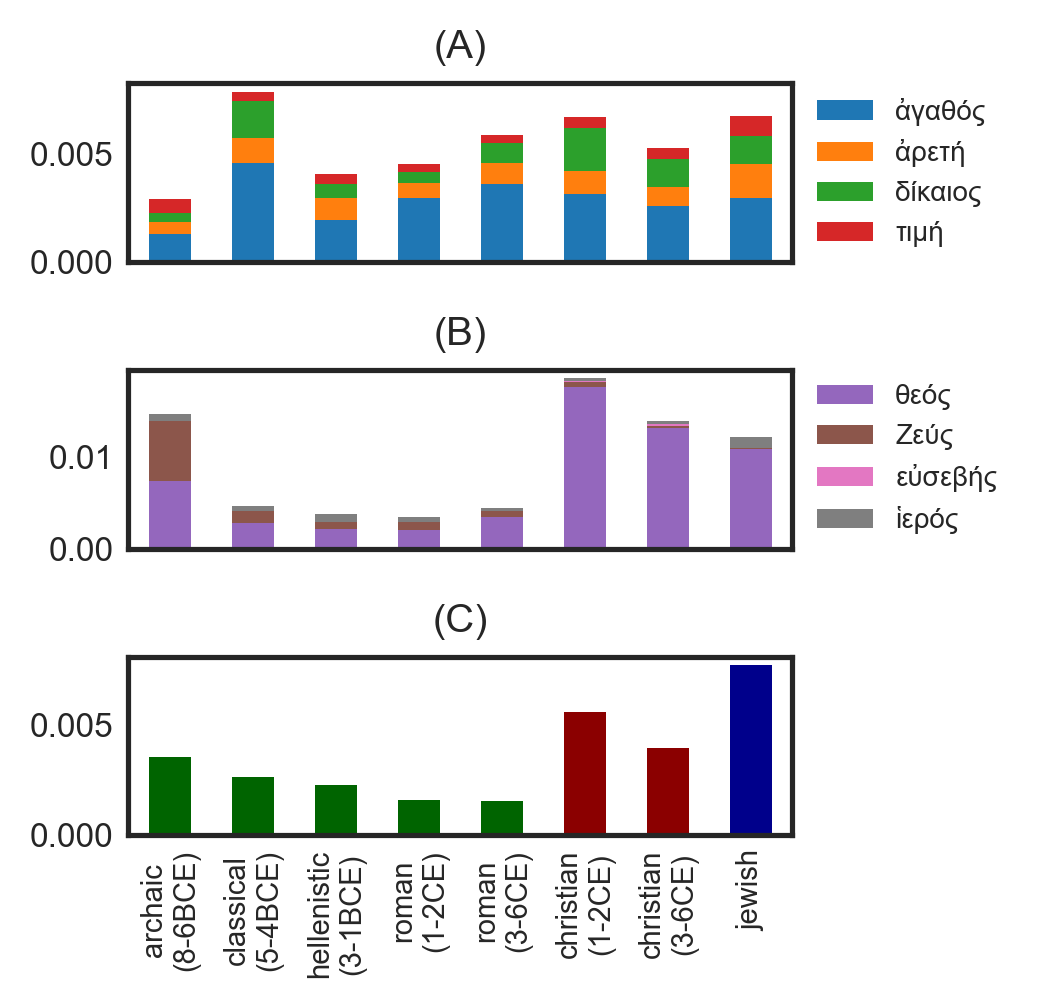

In [47]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

fig, [ax1, ax2, ax3] = plt.subplots(3,1, figsize=(3.5, 3.4), tight_layout=True)
subcorpora_targets_freqs[morality_final].plot(kind='bar', color=colors[:4], stacked=True, ax=ax1)
ax1.legend(fontsize="small", loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_xticklabels([])
ax1.set_title("(A)")

subcorpora_targets_freqs[religion_final].plot(kind='bar', color=colors[4:], stacked=True, ax=ax2)
ax2.legend(fontsize="small", loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_xticklabels([])
ax2.set_title("(B)")


religionmoral_cooc_freqs_df["religionmoral_freq"].plot.bar(color=subcorpora_colors_dict.values(), ax=ax3)
ax3.set_title("(C)")


ax3.set_xticklabels(subcorpora_labels, fontsize=7)


In [48]:
save_figure(fig, "subcorpora_frequencies+cooccurrences")

# Ngram data

In [49]:
#dictionary = Dictionary([vocabulary_balanced])
dictionary.add_documents([['moralindicator', "religionindicator"]])

In [50]:
class NgramCorpusBows:
    def __iter__(self):
        with open("../data/large_data/corpus_ngrams_bydocid_wide.txt", "r") as f:
            lines = f.readlines()
            for id in subcorpus_ids:
                lines_list = [l for l in range(ids_lines[id][0], ids_lines[id][1])]
                for li in lines_list:
                    try:
                        line = lines[li]
                        # for line index in subcorpus lineindexes
                        if bool(line.split()):
                            doc = line.split()
                            if [element for element in morality_final if element in doc]:
                                doc = doc + ["moralindicator"]
                            if [element for element in religion_final if element in doc]:
                                doc = doc + ["religionindicator"]
                            bow = dictionary.doc2bow(doc)
                            yield bow
                    except:
                        pass

In [51]:
class NgramCorpusSample(object):
    def __init__(self, ids_list, ids_lines, fname, sample_size=None, sample_seed=1, bow=False, dct=None):
        self.ids_list = ids_list
        self.fname = fname
        self.bow  = bow
        self.dct = dct
        self.sample_size = sample_size
        self.ids_lines = ids_lines
        lines_list = [ ]
        for id in ids_list:
            lines_list.extend([l for l in range(ids_lines[id][0], ids_lines[id][1])])
        ngrams_n = len(lines_list)
        if sample_size != None:
            np.random.seed(sample_seed)
            sample_inx =np.random.randint(0, ngrams_n, sample_size)
        else:
            sample_inx =[n for n in range(0, ngrams_n)]
        sample_lines = np.array(lines_list)[sample_inx]
        self.len = len(sample_lines)
        self.sample_lines = sample_lines
    def __len__(self):
        #[el for el in self]
        return self.len
    def __iter__(self):
        with open(self.fname, "r") as f:
            lines = f.readlines()
            for li in self.sample_lines:
                line = lines[li] # for line index in subcorpus lineindexes
                if bool(line.split()):
                    doc = line.split()
                    if [element for element in morality_final if element in doc]:
                        doc = doc + ["moralindicator"]
                    if [element for element in religion_final if element in doc]:
                        doc = doc + ["religionindicator"]
                    if (self.bow) & (self.dct != None):
                        yield self.dct.doc2bow(doc)
                    else:
                        yield doc

In [52]:
subcorpora_ids_dict.keys()

dict_keys(['pagan_archaic', 'pagan_classical', 'pagan_hellenistic', 'pagan_roman_peak', 'pagan_roman_late', 'christian_roman_peak', 'christian_roman_late', 'jewish'])

In [53]:
subcorpus_ids = subcorpora_ids_dict["pagan_archaic"]
len(subcorpus_ids)

59

In [54]:
subcorpus_ngrams =  NgramCorpusSample(subcorpus_ids, ids_lines, "../data/large_data/corpus_ngrams_bydocid_wide.txt", sample_size=300000) #, dct=dictionary, bow=True)

In [55]:
docs = [doc for doc in subcorpus_ngrams]
[doc for doc in docs if "religionindicator" in doc][:10]

[['γῆ',
  'ᾍδης',
  'νεκροδέγμων',
  'ἀπείρητος',
  'Τάρταρος',
  'ἵημι',
  'δεσμός',
  'ἄλυτος',
  'πελάζω',
  'θεός',
  'ἄλλος',
  'ἐπιγηθέω',
  'religionindicator'],
 ['θεός', 'εἰσοράω', 'κλέπτω', 'ὀτρύνω', 'εὔσκοπος', 'religionindicator'],
 ['Τυδεύς', 'υἱός', 'ἀπέχω', 'Ἴλιος', 'ἱερός', 'religionindicator'],
 ['πολύς',
  'μέλαθρον',
  'ἐκχέω',
  'ἀράχνιον',
  'λεπτός',
  'εἶδον',
  'θεός',
  'μάκαρ',
  'religionindicator'],
 ['ὄφις',
  'κεφαλή',
  'δεινός',
  'εἰμί',
  'φατειός',
  'φοβέω',
  'χθών',
  'φῦλον',
  'ἄνθρωπος',
  'πόλεμος',
  'Ζεύς',
  'υἱός',
  'φέρω',
  'religionindicator'],
 ['ἔχω', 'δίδωμι', 'θεός', 'ὑπομιμνήσκω', 'δημηγορία', 'religionindicator'],
 ['Θεσπρωτός', 'Ζεύς', 'τέρας', 'ἄπιστος', 'προσήγορος', 'religionindicator'],
 ['μῦθος', 'θεός', 'λαμβάνω', 'χρησμός', 'ἀσαφής', 'religionindicator'],
 ['ἄναξ', 'Πελασγός', 'ἱκέσιος', 'Ζεύς', 'κότος', 'religionindicator'],
 ['φιλέω', 'Παλλάς', 'Ζεύς', 'πατήρ', 'φιλέω', 'religionindicator']]

In [56]:
def get_ppmi_df(term_doc_mat, vocabulary):
    # Calculate co-occurrence matrix
    cooc = np.dot(term_doc_mat, term_doc_mat.T).toarray()
    total_cooc = cooc.sum()
    # Calculate the probabilities
    prob_A = np.diagonal(cooc) / total_cooc
    prob_B = prob_A
    joint_prob_AB = cooc / total_cooc
    #joint_prob_AB = joint_prob_AB ** 2  # Square the joint_prob_AB
    # Compute mutual information
    with np.errstate(divide='ignore', invalid='ignore'):
        outer_prob = np.outer(prob_A, prob_B)
        MI = np.where(outer_prob != 0, np.log2(
            np.divide(joint_prob_AB, outer_prob, out=np.ones_like(joint_prob_AB), where=outer_prob != 0)), 0)
    MI = np.maximum(MI, 0)  # make the MI matrix as PPMI matrix
    # Convert the PPMI matrix into a DataFrame
    PPMI_matrix_df = pd.DataFrame(MI, columns=vocabulary, index=vocabulary)
    # Replace infinities with NaN
    PPMI_matrix_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return PPMI_matrix_df

def normalize(matrix_df):
    # Get the absolute max value
    max_value = matrix_df.abs().max().max()
    # Divide each entry of the matrix by the maximum value
    normalized_matrix = matrix_df / max_value
    return normalized_matrix

In [57]:
%%time
sample_size = 3000
iterations_dfs = []
subcorpora_indicators_mi = []
for sub in subcorpora_ids_dict.keys():
    subcorpus_data = {"subcorpus" : sub}
    for iteration_n in range(1, 2):
            subcorpus_ids = subcorpora_ids_dict[sub]
            corpus =  NgramCorpusSample(subcorpus_ids, ids_lines, "../data/large_data/corpus_ngrams_bydocid_wide.txt", sample_size=sample_size, sample_seed=iteration_n, dct=dictionary, bow=True)
            dct_subset = Dictionary.from_corpus(corpus, id2word=dictionary)
            term_doc_mat = corpus2csc(corpus, num_terms=len(dct_subset))
            vocabulary = list(dct_subset.values())
            mi_matrix = get_ppmi_df(term_doc_mat, vocabulary=vocabulary)
            subcorpus_data["moralreligion_mi_" + str(iteration_n)] = mi_matrix["moralindicator"]["religionindicator"] /  max([mi_matrix["moralindicator"].max(), mi_matrix["religionindicator"].max()])
    subcorpora_indicators_mi.append(subcorpus_data)

CPU times: user 30.3 s, sys: 6.84 s, total: 37.1 s
Wall time: 40.2 s


In [58]:
subcorpora_indicators_mi_df = pd.DataFrame(subcorpora_indicators_mi)

In [59]:
subcorpora_indicators_mi_df

,subcorpus,moralreligion_mi_1
0,pagan_archaic,0.485538
1,pagan_classical,0.506192
2,pagan_hellenistic,0.575346
3,pagan_roman_peak,0.627430
4,pagan_roman_late,0.524723
5,christian_roman_peak,0.525693
6,christian_roman_late,0.548714
7,jewish,0.512305


In [60]:
subcorpora_indicators_mi_df.to_json("../data/subcorpora_indicators_mi_df.json")

In [61]:
subcorpora_indicators_mi_df.set_index("subcorpus", inplace=True)

[Text(1, 0, 'archaic\n(8-6BCE)'),
 Text(2, 0, 'classical\n(5-4BCE)'),
 Text(3, 0, 'hellenistic\n(3-1BCE)'),
 Text(4, 0, 'roman\n(1-2CE)'),
 Text(5, 0, 'roman\n(3-6CE)'),
 Text(6, 0, 'christian\n(1-2CE)'),
 Text(7, 0, 'christian\n(3-6CE)'),
 Text(8, 0, 'jewish')]

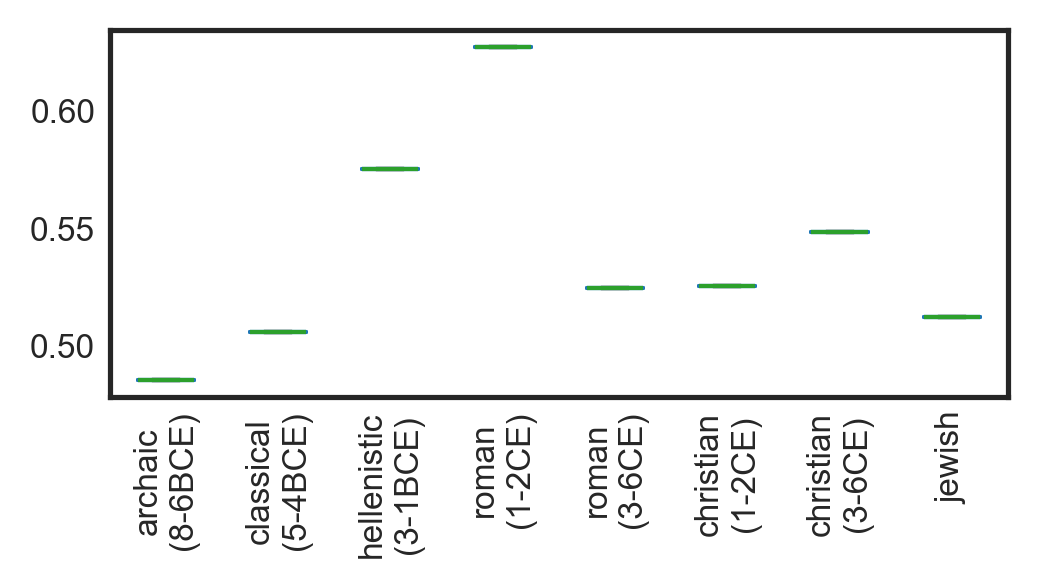

In [62]:
fig, ax = plt.subplots(figsize=(3.5, 2), tight_layout=True)
subcorpora_indicators_mi_df.T.boxplot(grid=False, vert=True, ax=ax)
ax.set_xticklabels(subcorpora_labels, rotation=90)

In [63]:
subcorpora_indicators_mi_df.

SyntaxError: invalid syntax (3179556373.py, line 1)

In [ ]:
df = subcorpora_indicators_mi_df.T

# MI by centuries

In [ ]:
centuries_targets_mi = []
for cent in centuries:
    century_data = {}
    century_data["cent_label"] = cent[0]
    century_data["cent_mid"] = (cent[1] + cent[2]) / 2
    LAGT_subset = LAGT[LAGT["cents"].apply(lambda x: cent[0] in x)]
    subcorpus_ids = LAGT_subset["doc_id"].tolist()
    corpus = NgramCorpusBows()
    #corpus = [dictionary.doc2bow(sent) for sents in LAGT_subset["lemmatized_sentences"] for sent in sents]
    dct_subset = Dictionary.from_corpus(corpus, id2word=dictionary)
    term_doc_mat = corpus2csc(corpus, num_terms=len(dct_subset))
    vocabulary = list(dct_subset.values())
    mi_matrix = get_ppmi_df(term_doc_mat, vocabulary=vocabulary)
    century_data["moralreligion_mi"] = mi_matrix["moralindicator"]["religionindicator"] /  max([mi_matrix["moralindicator"].max(), mi_matrix["religionindicator"].max()])
    for rel_term in religion_final:
        for mor_term in morality_final:
            century_data[rel_term + "_" + mor_term + "_mi"] = mi_matrix[rel_term][mor_term] /  max([mi_matrix[rel_term].max(), mi_matrix[mor_term].max()])
    centuries_targets_mi.append(century_data)


In [ ]:
centuries_targets_mi_df = pd.DataFrame(centuries_targets_mi)
centuries_targets_mi_df.set_index("cent_mid", inplace=True)
centuries_targets_mi_df

In [ ]:
fig, ax = plt.subplots(figsize=(3.5, 2),tight_layout=True)
ax.grid(visible=True, axis="x")
centuries_targets_mi_df["moralreligion_mi"].plot(ax=ax, color="black", linewidth=1)
ax.set_xlim(-825,625)
ax.set_xticks([el+1 if el==0 else el for el in range(-800,700,100)])
ax.set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,700,100)], rotation=90)


In [ ]:
save_figure(fig, "centuries_moralrelogion_mi")

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(3.5, 3),tight_layout=True)
linestyles = ['-', '--', '-.', ':']
#linecolors = ['#C0C0C0', '#808080', '#505050', '#000000']
lighter_colors = [
    (0.0, 0.4, 0.4),  # lighter cyan
    (0.0, 0.4, 0.0),  # lighter green
    (0.4, 0.0, 0.4),  # lighter magenta
    (0.0, 0.0, 0.4)  # lighter blue
]

for rel_term, ax in zip(religion_final, axs):
    ax.legend(fontsize="small", loc='center left', bbox_to_anchor=(1, 0.5))
    for period, color_per in zip(periods_dict.keys(), periods_colors):
        ax.axvspan(periods_dict[period]["startdate"], periods_dict[period]["enddate"], color=color_per, zorder=-1)
    for mor_term, color in zip(morality_final, lighter_colors):
        centuries_targets_mi_df[rel_term + "_" + mor_term + "_mi"].plot(ax=ax, color=color, linewidth=1)
    #y_max = centuries_targets_df[target + "_freq"].max().round(4)
    #ax.set_ylim(0, y_max * 1.1)
    #ax.set_yticks([int(0), y_max])
    #ax.set_yticklabels([str(tick) for tick in [int(0), y_max]])
    ax.set_xlabel("")
    ax.set_xticklabels([])
    #ax.grid(visible=True, axis="y")
    ax.grid(visible=True, axis="x")
    #ax.set_title(target, pad=0)
    ax.set_xticks([el+1 if el==0 else el for el in range(-800,700,100)])
    ax.set_xlim(-825,625)
    ax.legend(fontsize="small", loc='center left', bbox_to_anchor=(1, 0.5))

axs[3].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,700,100)], rotation=90)
    
axs[3].set_xlabel("year")

#fig.text(-0.02, 0.5, 'word frequency', va='center', rotation='vertical')

In [ ]:
save_figure(fig, "centuries_mi_by_religion")

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(3.5, 3),tight_layout=True)
linestyles = ['-', '--', '-.', ':']
#linecolors = ['#C0C0C0', '#808080', '#505050', '#000000']
lighter_colors = [
    (0.0, 0.4, 0.4),  # lighter cyan
    (0.0, 0.4, 0.0),  # lighter green
    (0.4, 0.0, 0.4),  # lighter magenta
    (0.0, 0.0, 0.4)  # lighter blue
]

for mor_term, ax in zip(morality_final, axs):
    ax.legend(fontsize="small", loc='center left', bbox_to_anchor=(1, 0.5))
    for period, color_per in zip(periods_dict.keys(), periods_colors):
        ax.axvspan(periods_dict[period]["startdate"], periods_dict[period]["enddate"], color=color_per, zorder=-1)
    for rel_term, color in zip(religion_final, lighter_colors):
        centuries_targets_mi_df[rel_term + "_" + mor_term + "_mi"].plot(ax=ax, color=color, linewidth=1)
    #y_max = centuries_targets_df[target + "_freq"].max().round(4)
    #ax.set_ylim(0, y_max * 1.1)
    #ax.set_yticks([int(0), y_max])
    #ax.set_yticklabels([str(tick) for tick in [int(0), y_max]])
    ax.set_xlabel("")
    ax.set_xticklabels([])
    #ax.grid(visible=True, axis="y")
    ax.grid(visible=True, axis="x")
    #ax.set_title(target, pad=0)
    ax.set_xticks([el+1 if el==0 else el for el in range(-800,700,100)])
    ax.set_xlim(-825,625)
    ax.legend(fontsize="small", loc='center left', bbox_to_anchor=(1, 0.35))

axs[3].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,700,100)], rotation=90)

axs[3].set_xlabel("year")

In [ ]:
save_figure(fig, "centuries_mi_by_morality")
